# NLP/ NLU Topic Naming using Cosine Similarity and Triangulation





# 1. Import Libraries

In [0]:
import re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import logging
import logging.config

#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import warnings

warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings('ignore',message="Precision")

logging.getLogger("pdfminer").setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Covert PDF article to Text function

In [0]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    file = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(file, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    device.close()
    retstr.close()
    return text

# 3. Data loading and preparation

In [0]:
file1 = 'doc_3Trademark_Transfer_Agreement.pdf'
link1 = 'https://drive.google.com/open?id=1ZVMK0KZg2bSM5qdIzCAY1H_I5g94pUSq' 
fluff, id = link1.split('=')
print('File Name = ', file1)
print('File ID = ', id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile(file1) 

File Name =  doc_3Trademark_Transfer_Agreement.pdf
File ID =  1ZVMK0KZg2bSM5qdIzCAY1H_I5g94pUSq


In [0]:
lone=convert_pdf_to_txt(file1)

In [0]:
f=open('xxx.txt','w')
f.write(lone)
f.close()

In [0]:
with open('xxx.txt') as f:
    clean_cont = f.read().splitlines()

# 4. Data cleaning

In [0]:
clean_cont

['TRADEMARK AND DOMAIN NAME AGREEMENT ',
 '',
 'This agreement (the “Agreement”) is by and between ____________________________ ',
 '',
 ' ',
 ' ',
 '(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  ',
 '201[__] (the “Effective Date”). ',
 ' ',
 '',
 'WHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the ',
 '',
 '“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); ',
 '',
 ' ',
 'WHEREAS, Party is desirous of Eclipse to initiate a project or working group with a ',
 '',
 'name based on the Trademark (the “Project Initiation”); ',
 '',
 ' ',
 'WHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s ',
 '',
 'rights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain ',
 'continuing usage rights of the Trademarks; ',
 '',
 ' ',
 'WHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to ',
 'h

# 5. Remove unwanted characters and clean the data set

In [0]:
shear=[i.replace('\xe2\x80\x9c','') for i in clean_cont ]
shear=[i.replace('\xe2\x80\x9d','') for i in shear ]
shear=[i.replace('\xe2\x80\x99s','') for i in shear ]

shears = [x for x in shear if x != ' ']
shearss = [x for x in shears if x != '']

In [0]:
shear

['TRADEMARK AND DOMAIN NAME AGREEMENT ',
 '',
 'This agreement (the “Agreement”) is by and between ____________________________ ',
 '',
 ' ',
 ' ',
 '(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  ',
 '201[__] (the “Effective Date”). ',
 ' ',
 '',
 'WHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the ',
 '',
 '“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); ',
 '',
 ' ',
 'WHEREAS, Party is desirous of Eclipse to initiate a project or working group with a ',
 '',
 'name based on the Trademark (the “Project Initiation”); ',
 '',
 ' ',
 'WHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s ',
 '',
 'rights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain ',
 'continuing usage rights of the Trademarks; ',
 '',
 ' ',
 'WHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to ',
 'h

In [0]:
shears

['TRADEMARK AND DOMAIN NAME AGREEMENT ',
 '',
 'This agreement (the “Agreement”) is by and between ____________________________ ',
 '',
 '(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  ',
 '201[__] (the “Effective Date”). ',
 '',
 'WHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the ',
 '',
 '“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); ',
 '',
 'WHEREAS, Party is desirous of Eclipse to initiate a project or working group with a ',
 '',
 'name based on the Trademark (the “Project Initiation”); ',
 '',
 'WHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s ',
 '',
 'rights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain ',
 'continuing usage rights of the Trademarks; ',
 '',
 'WHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to ',
 'have any related Domain Names initial

In [0]:
shearss

['TRADEMARK AND DOMAIN NAME AGREEMENT ',
 'This agreement (the “Agreement”) is by and between ____________________________ ',
 '(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  ',
 '201[__] (the “Effective Date”). ',
 'WHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the ',
 '“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); ',
 'WHEREAS, Party is desirous of Eclipse to initiate a project or working group with a ',
 'name based on the Trademark (the “Project Initiation”); ',
 'WHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s ',
 'rights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain ',
 'continuing usage rights of the Trademarks; ',
 'WHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to ',
 'have any related Domain Names initially redirect to a URL designated by Eclipse an

# 6. Use regexp to remove duplicate spaces

In [0]:
dubby=[re.sub("[^a-zA-Z]+", " ", s) for s in shearss]

In [0]:
dubby

['TRADEMARK AND DOMAIN NAME AGREEMENT ',
 'This agreement the Agreement is by and between ',
 ' Party and Eclipse Foundation Inc Eclipse and is effective as of ',
 ' the Effective Date ',
 'WHEREAS Party is the owner of certain trademarks identified in Exhibit A the ',
 ' Trademarks and of certain domain names identified in Exhibit A the Domain Names ',
 'WHEREAS Party is desirous of Eclipse to initiate a project or working group with a ',
 'name based on the Trademark the Project Initiation ',
 'WHEREAS to accommodate the Project Initiation Party desires to transfer all of Party s ',
 'rights title and interest in and to the Trademarks to Eclipse and to thereafter have certain ',
 'continuing usage rights of the Trademarks ',
 'WHEREAS to accommodate the Project Initiation the Parties may mutually agree to ',
 'have any related Domain Names initially redirect to a URL designated by Eclipse and that the ',
 'Domain Names are subsequently transferred to Eclipse ',
 'In consideration of 

# 7. Topic Modeling

In [0]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import numpy as np
%pylab
%matplotlib inline


Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


# 8. Use Stop Words to clean the data set

In [0]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# 9. Using CountVectorizer for LDA. Stop Words used english

In [0]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')

In [0]:
dtm=vect.fit_transform(dubby)

In [0]:
dtm

<171x326 sparse matrix of type '<class 'numpy.int64'>'
	with 647 stored elements in Compressed Sparse Row format>

#10. Count Vectorizer data frame

In [0]:
pdf = pd.DataFrame(dtm.toarray(),columns=vect.get_feature_names())
pdf.head()

,accommodate,accordance,acknowledged,action,actions,additional,address,advised,affiliated,aggrieved,agree,agreement,agreements,agrees,amended,amendment,applicable,applications,appropriate,approves,arising,assign,assigned,assignment,assigns,authority,authorized,authorizes,available,based,bind,breach,business,canada,capabilities,captions,cause,caused,centrepointe,certain,...,supersede,supersedes,symbolized,term,terms,testifying,thereof,thing,time,title,tracking,trademark,trademarks,transfer,transferred,transfers,unenforceable,united,unregistered,unto,url,urls,usage,use,valuable,venturers,version,vest,waiver,warranties,warrants,warranty,way,whereof,witness,working,writing,written,www,york
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 11. Implementing LDA for the vectorized dataset

In [0]:
lda=LatentDirichletAllocation(n_components=5)

In [0]:
lda.fit_transform(dtm)
print()

In [0]:
lda_dtf=lda.fit_transform(dtm)


# 12. Print all words after the lda is run

In [0]:
import numpy as np
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())
print(features)
words = list(features)

['accommodate' 'accordance' 'acknowledged' 'action' 'actions' 'additional'
 'address' 'advised' 'affiliated' 'aggrieved' 'agree' 'agreement'
 'agreements' 'agrees' 'amended' 'amendment' 'applicable' 'applications'
 'appropriate' 'approves' 'arising' 'assign' 'assigned' 'assignment'
 'assigns' 'authority' 'authorized' 'authorizes' 'available' 'based'
 'bind' 'breach' 'business' 'canada' 'capabilities' 'captions' 'cause'
 'caused' 'centrepointe' 'certain' 'certified' 'commercial' 'commissioner'
 'common' 'communications' 'company' 'competent' 'condition' 'confirms'
 'conflicts' 'consent' 'consequential' 'consideration' 'constitute'
 'construed' 'content' 'continuing' 'contractors' 'convenience' 'convey'
 'costs' 'country' 'courier' 'court' 'current' 'currently' 'damages'
 'date' 'dated' 'days' 'dealings' 'deemed' 'delivered' 'delivery'
 'demands' 'designated' 'desires' 'desirous' 'determined' 'direct'
 'directly' 'disclaimer' 'disclaims' 'discussions' 'documents' 'domain'
 'domains' 'dri

# 12. Function to print the topics in a list. Topics 0-4 are selected each having 10 words

In [0]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=5, n_words=10):
    
    global tdf
    tdf = pd.DataFrame()
    tdf = pd.DataFrame(columns=['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4'])
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        print
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(*feature_names[sorting[these_topics, i]]))
                rowwords = list(feature_names[sorting[these_topics, i]])
                tdf = tdf.append(pd.Series(rowwords, index=['topic 0', 'topic 1', 'topic 2', 'topic 3', 'topic 4']), ignore_index=True)
            except:
                pass
        print("\n")



# 14. Printing all the required topics

In [0]:
print_topics(topics=range(5), feature_names=features, sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
party         party         condition     domain        agreement     
project       assignment    term          names         eclipse       
page          trademarks    agreement     trademarks    title         
remedies      limitation    waiver        eclipse       party         
shall         ownership     right         related       trademarks    
initiation    warranties    parties       accordance    shall         
trademark     shall         trademark     use           right         
eclipse       list          written       trademark     rights        
provided      constitute    trademarks    shall         date          
rights        thereof       hereto        including     entire        




# 15. Convert to data set

In [0]:
tdf.head(10)

,topic 0,topic 1,topic 2,topic 3,topic 4
0,party,party,condition,domain,agreement
1,project,assignment,term,names,eclipse
2,page,trademarks,agreement,trademarks,title
3,remedies,limitation,waiver,eclipse,party
4,shall,ownership,right,related,trademarks
5,initiation,warranties,parties,accordance,shall
6,trademark,shall,trademark,use,right
7,eclipse,list,written,trademark,rights
8,provided,constitute,trademarks,shall,date
9,rights,thereof,hereto,including,entire


# 16. Multinomial NB for finding topic name

,Text,Title
0,party project page remedies shall initiation t...,party
1,party assignment trademarks limitation ownersh...,trademarks
2,condition term agreement waiver right parties ...,transfer
3,domain names trademarks eclipse related accord...,jurisdiction
4,agreement eclipse title party trademarks shall...,topic4


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
X and y
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [1 0 0 0 0]]
['party' 'trademarks' 'transfer' 'jurisdiction' 'topic4']
trains
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]
[[1 0 0 0 0]]
['party' 'trademarks' 'transfer' 'jurisdiction']
['topic4']
trains print done
['jurisdiction']


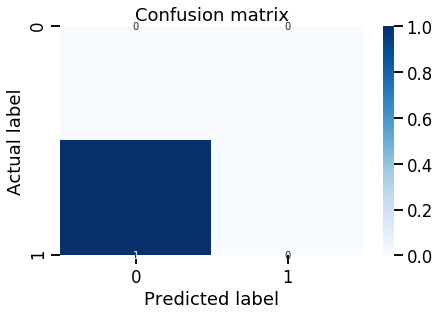

In [0]:
import pandas as pd 
import re 
import nltk 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
import seaborn as sns
import matplotlib.pyplot as plt

# maually renaming topics for first 4
# automatically finding topic name based on Multinomial NB
dataset = [
    [" ".join(tdf['topic 0'].tolist()), 'party'],
    [" ".join(tdf['topic 1'].tolist()), 'trademarks'],
    [" ".join(tdf['topic 2'].tolist()), 'transfer'],
    [" ".join(tdf['topic 3'].tolist()), 'jurisdiction'],
    [" ".join(tdf['topic 4'].tolist()), 'topic4']
]

dataset = pd.DataFrame(dataset) 
dataset.columns = ["Text", "Title"] 

display(dataset.head())

nltk.download('stopwords') 

corpus = [] 

for i in range(0, 5): 
    text = re.sub('[^a-zA-Z]', '', dataset['Text'][i]) 
    text = text.lower() 
    text = text.split() 
    ps = PorterStemmer() 
    text = ''.join(text) 
    corpus.append(text) 

# creating bag of words model 
cv = CountVectorizer(max_features = 1500) 

X = cv.fit_transform(corpus).toarray() 
y = dataset.iloc[:, 1].values 

print('X and y')
print(X)
print(y)

# splitting the data set into training set and test set 
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0,shuffle=False) 

print('trains')
print(X_train)
print(X_test)
print(y_train)
print(y_test)
print('trains print done')

# fitting naive bayes to the training set 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import confusion_matrix 
from sklearn.naive_bayes import MultinomialNB

#classifier = GaussianNB(); 
classifier = MultinomialNB(); 
classifier.fit(X_train, y_train) 

# predicting test set results 
y_pred = classifier.predict(X_test) 

print(y_pred)
topic4name = y_pred[0]
# making the confusion matrix 
cm = confusion_matrix(y_test, y_pred) 
cm 
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="Blues" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

# 17. Multinomial NB preidicted name for topic4

In [0]:
print(topic4name)

jurisdiction


In [0]:
import math
from collections import Counter

def build_vector(iterable1, iterable2):
    counter1 = Counter(iterable1)
    counter2 = Counter(iterable2)
    all_items = set(counter1.keys()).union(set(counter2.keys()))
    vector1 = [counter1[k] for k in all_items]
    vector2 = [counter2[k] for k in all_items]
    return vector1, vector2

def cosim(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)

lst = tdf['topic 4'].tolist()

s1 = s2 = 0
sf1 = sf2 = ''
highcosval = 0
for l1 in lst:
    for l2 in lst:
        if l1 is not l2:
            v1, v2 = build_vector(l1, l2)
            cosval = cosim(v1, v2)
            #print(cosval, l1, l2)
            if cosval >= highcosval:
                highcosval = cosval
                sf1 = l1
                sf2 = l2
    
print(sf1, sf2, highcosval)


rights right 0.9128709291752769


# 18. High Cosine Score word in the topic list

In [0]:
print(sf1)

rights


# 19. Proposed Topic 4 name based on Multinomial NB and Cosine Similarity


In [0]:
print('Probable topic4 name from Other topic names and high coisine word in the topic 4 list:\n')
topic4 = sf1 + ' ' + topic4name
print(topic4)

Probable topic4 name from Other topic names and high coisine word in the topic 4 list:

rights jurisdiction


In [0]:
#dataset.at[4, 'Title'] = topic4

display(dataset)


,Text,Title
0,party project page remedies shall initiation t...,party
1,party assignment trademarks limitation ownersh...,trademarks
2,condition term agreement waiver right parties ...,transfer
3,domain names trademarks eclipse related accord...,jurisdiction
4,agreement eclipse title party trademarks shall...,topic4


# 20. Doc2Vector Model for the LDA

In [0]:
import nltk
#nltk.download()
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 21. Doc2Vector Train And Test set. 

In [0]:
#Split the df for training and testing
train, test = train_test_split(dataset.reset_index(drop=True), test_size=.2, random_state=0,shuffle=False)

#print(train)
print(test)

#The Doc2Vec model takes 'tagged_documents'
#tag the training data
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(train.Text)]

#tag testing data
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(test.Text)]

                                                Text   Title
4  agreement eclipse title party trademarks shall...  topic4


# 22. Building the Vocabulary for Doc2Vec model

In [0]:
model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=5, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=16)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)

# 23. Using Max_epochs 25 to build the model

In [0]:
#max training epochs
max_epochs = 25

#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
   
   

print("done!")
t2 = time.time()    
model.save("5klects1.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
done!
Time: 0.9554274082183838


# 24. Find Most Similar Word using doc2vector

In [0]:
mostsimwordlist = model.most_similar(['eclipse'])
print(mostsimwordlist)
doc2vecword = mostsimwordlist[0][0]
print(doc2vecword)

[('party', 0.18174314498901367), ('shall', -0.02029164880514145), ('trademarks', -0.05874306708574295), ('trademark', -0.11955813318490982)]
party


# 25. Using the infer vector method to convert the test sentences into vectors

In [0]:
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train.Title

X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test.Title

In [0]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))


# 26. Plotting the Doc2Vector model predition using KMEANS

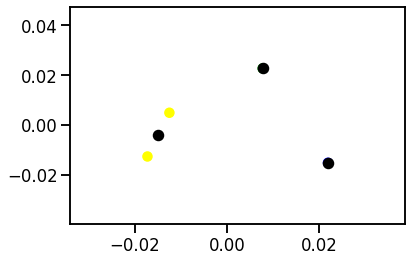

In [0]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

kmeans_model = KMeans(n_clusters = 3, random_state = 0, max_iter = 500)
#kmeans_model = KNeighborsClassifier(n_neighbors=2)

X = kmeans_model.fit(model.docvecs.doctag_syn0)
labels=kmeans_model.labels_.tolist()
l = kmeans_model.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure
label1 = ['#FFFF00', '#008000', '#0000FF', '#800080']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)
centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], s = 100, c = 'black', label = 'Centroids', marker = 'o')
plt.show()

# 27. Final topic name using triangulation of Multinomial NB, Cosine Similarity and predicted Doc2Vector model most similar word

In [0]:
finaltopicname = sf1 + ' ' + topic4name + ' ' + doc2vecword
print(finaltopicname)

rights jurisdiction party


In [0]:
dataset.at[4, 'Title'] = finaltopicname
display(dataset)


,Text,Title
0,party project page remedies shall initiation t...,party
1,party assignment trademarks limitation ownersh...,trademarks
2,condition term agreement waiver right parties ...,transfer
3,domain names trademarks eclipse related accord...,jurisdiction
4,agreement eclipse title party trademarks shall...,rights jurisdiction party


# 28. TSNE Visualization for the result

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

TSNEVisualizer(alpha=0.7,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f538de74cf8>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=None, random_state=None)

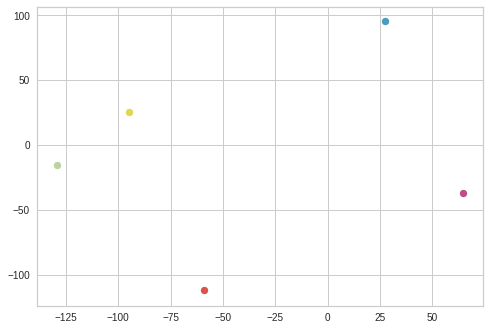

In [0]:
from gensim import corpora, models
np.random.seed(2017)
texts = dataset.values
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = models.ldamodel.LdaModel(corpus, id2word=dictionary, 
                                    num_topics=8, passes=5, minimum_probability=0)
ldamodel.print_topics()
hm = np.array([[y for (x,y) in ldamodel[corpus[i]]] for i in range(len(corpus))])
tsne = TSNE(random_state=2017, perplexity=30, early_exaggeration=120)
embedding = tsne.fit_transform(hm)
embedding = pd.DataFrame(embedding, columns=['x','y'])
embedding['hue'] = hm.argmax(axis=1)

from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
